In [ ]:
# Resources:
# https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py : For ViT
# https://github.com/huggingface/transformers/blob/main/src/transformers/models/gpt2/modeling_gpt2.py : For GPT2

In [ ]:
import os
os._exit(0)

In [ ]:
import os
from accelerate.utils import write_basic_config

write_basic_config()  # Write a config file
os._exit(0)  # Restart the notebook

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from timm import create_model
from transformers import GPT2LMHeadModel, GPT2Tokenizer, ViTModel
import torchvision.transforms as transforms
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
import torch.optim as optim
import wandb
import datasets
import os
from accelerate import notebook_launcher
from accelerate import Accelerator
import matplotlib.pyplot as plt
import gc

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
import pandas as pd
from pathlib import Path
import json

In [ ]:
# This block of code is taken from https://www.kaggle.com/code/shreydan/visiongpt2-image-captioning-pytorch#Model
sample_tfms = [
    A.HorizontalFlip(),
    A.RandomBrightnessContrast(),
    A.ColorJitter(),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.3, rotate_limit=45, p=0.5),
    A.HueSaturationValue(p=0.3),
]
train_tfms = A.Compose([
    *sample_tfms,
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])
valid_tfms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=[0.5,0.5,0.5],std=[0.5,0.5,0.5],always_apply=True),
    ToTensorV2()
])

class Dataset:
    def __init__(self, df, tfms):
        self.df = df
        self.tfms = tfms
    def __len__(self):
        return len(self.df)
    def __getitem__(self,idx):
        sample = self.df.iloc[idx,:]
        image = sample['image']
        caption = sample['caption']
        image = Image.open(image).convert('RGB')
        image = np.array(image)
        augs = self.tfms(image=image)
        image = augs['image']
        labels = tokenizer(
            caption,
            truncation=True)['input_ids']
        caption = f"<|endoftext|>{caption}"
        input_ids = tokenizer(
            caption,
            truncation=True)['input_ids'][:-1]
        #labels[:-1] = input_ids[1:]
        return image,input_ids,labels
    
# COCO 2017
base_path = Path('/kaggle/input/coco-2017-dataset/coco2017')
annot = base_path / 'annotations' / 'captions_train2017.json'
with open(annot, 'r') as f:
    data = json.load(f)
    data = data['annotations']

samples = []

for sample in data:
    im = '%012d.jpg' % sample['image_id']
    samples.append([im, sample['caption']])

df = pd.DataFrame(samples, columns=['image', 'caption'])
df['image'] = df['image'].apply(
    lambda x: base_path / 'train2017' / x
)
df = df.sample(150000)
df = df.reset_index(drop=True)
df.head()

,image,caption
0,/kaggle/input/coco-2017-dataset/coco2017/train...,A skier jumping off a small jump in the snow.
1,/kaggle/input/coco-2017-dataset/coco2017/train...,a female in a black and white shirt is playing...
2,/kaggle/input/coco-2017-dataset/coco2017/train...,Someone holding a carrot and feeding a giraffe.
3,/kaggle/input/coco-2017-dataset/coco2017/train...,A white and yellow bus driving down a winding ...
4,/kaggle/input/coco-2017-dataset/coco2017/train...,A man sitting in the snow while attached to a ...


In [3]:
train_df, val_df = train_test_split(df,test_size=0.1)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)
print(len(train_df),len(val_df))

train_ds = Dataset(train_df,train_tfms)
val_ds = Dataset(val_df,valid_tfms)

135000 15000


In [4]:
# sampled_df = df.sample(n=10)
# fig, axs = plt.subplots(5, 2, figsize=(10, 15))

# for i, row in enumerate(sampled_df.iterrows()):
#     ax = axs[i // 2, i % 2]
#     image_path = row[1]['image']
#     caption = row[1]['caption']
#     image = Image.open(image_path)
#     ax.imshow(image)
#     ax.axis('off')
#     ax.set_title(caption)

# plt.tight_layout()
# plt.show()

In [5]:
def collate_fn(batch):
    image = [i[0] for i in batch]
    input_ids = [i[1] for i in batch]
    labels = [i[2] for i in batch]
    image = torch.stack(image,dim=0)
    input_ids = tokenizer.pad(
        {'input_ids':input_ids},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    labels = tokenizer.pad(
        {'input_ids':labels},
        padding='longest',
        return_attention_mask=False,
        return_tensors='pt'
    )['input_ids']
    
    mask = (input_ids!=tokenizer.pad_token_id).long()
    mask[0] = 1
    labels[mask==0]=-100
    return image, input_ids, labels

In [6]:
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

In [7]:
dl = torch.utils.data.DataLoader(train_ds,shuffle=True,batch_size=2,collate_fn=collate_fn)
_,c,l = next(iter(dl))
print(c[0])
print(l[0])

tensor([50256, 12510, 41271,  1671,   292,  6155,   319,   257,  2975,  1290,
         2157,   257,  1097])
tensor([12510, 41271,  1671,   292,  6155,   319,   257,  2975,  1290,  2157,
          257,  1097,    13])


In [8]:
class Conv1D(nn.Module):
    """
    1D-convolutional layer as defined by Radford et al. for OpenAI GPT (and also used in GPT-2).

    Basically works like a linear layer but the weights are transposed.

    Args:
        nf (`int`): The number of output features.
        nx (`int`): The number of input features.
    """

    def __init__(self, nf, nx):
        super().__init__()
        self.nf = nf
        self.weight = nn.Parameter(torch.empty(nx, nf))
        self.bias = nn.Parameter(torch.zeros(nf))
        nn.init.normal_(self.weight, std=0.02)

    def forward(self, x):
        size_out = x.size()[:-1] + (self.nf,)
        x = torch.addmm(self.bias, x.view(-1, x.size(-1)), self.weight)
        x = x.view(size_out)
        return x

In [9]:
# Multi head self and cross attention
class GPT2Attention(nn.Module):
    def __init__(self, config, is_cross_attention=False, is_causal=True):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.n_heads = config.num_attention_heads
        self.head_size = self.embed_dim // self.n_heads
        self.split_size = self.embed_dim
        self.is_cross_attention = is_cross_attention
        self.scale = self.head_size ** -0.5
        if self.is_cross_attention:
            self.c_attn = Conv1D(2 * self.embed_dim, self.embed_dim)
            self.q_attn = Conv1D(self.embed_dim, self.embed_dim)
        else:
            self.c_attn = Conv1D(3 * self.embed_dim, self.embed_dim)
        self.c_proj = Conv1D(self.embed_dim, self.embed_dim)

        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        self.is_causal = is_causal

        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if ((not self.flash) and self.is_causal):
            self.register_buffer("tril", torch.tril(torch.ones(1, 1, config.n_positions, config.n_positions)))

    def forward(self, x, y=None, attn_mask=None):
        B, T_dec, C = x.shape
        if y is None:
            y = x
        B, T_enc, C = y.shape
        if self.is_cross_attention:
            q = self.q_attn(x).view(B, T_dec, self.n_heads, self.head_size).transpose(1,2)
            k, v = self.c_attn(y).split(C, dim=-1)
            k = k.view(B, T_enc, self.n_heads, self.head_size).transpose(1,2)
            v = v.view(B, T_enc, self.n_heads, self.head_size).transpose(1,2)
        else:
            q, k, v = self.c_attn(x).split(C, dim=-1)
            q = q.view(B, T_dec, self.n_heads, self.head_size).transpose(1,2)
            k = k.view(B, T_enc, self.n_heads, self.head_size).transpose(1,2)
            v = v.view(B, T_enc, self.n_heads, self.head_size).transpose(1,2)

        if self.flash:
            attn = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, is_causal=self.is_causal)
        else:
            attn_weights = q @ k.transpose(-2, -1)
            attn_weights = attn_weights / self.scale
            if self.is_causal:
                attn_weights = attn_weights.masked_fill(self.tril == 0, float('-inf'))
            attn_weights = F.softmax(attn_weights, dim=-1)
            attn_weights = self.attn_dropout(attn_weights)
            attn = attn_weights @ v
        attn = attn.transpose(1, 2).contiguous().view(B, T_dec, C)
        attn = self.resid_dropout(self.c_proj(attn))
        return attn
    
# MLP
class GPT2MLP(nn.Module):
    def __init__(self, intermediate_size, config):
        super().__init__()
        embed_dim = config.hidden_size
        self.c_fc = Conv1D(intermediate_size, embed_dim)
        self.c_proj = Conv1D(embed_dim, intermediate_size)
        self.act = nn.GELU()
        self.dropout = nn.Dropout(config.resid_pdrop)

    def forward(self, hidden_states):
        hidden_states = self.c_fc(hidden_states)
        hidden_states = self.act(hidden_states)
        hidden_states = self.c_proj(hidden_states)
        hidden_states = self.dropout(hidden_states)
        return hidden_states
    
# Transformer blocks
class GPT2Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.embed_dim = config.hidden_size
        hidden_size = self.embed_dim
        inner_dim = config.n_inner if config.n_inner is not None else 4 * hidden_size
        
        self.ln_1 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.attn = GPT2Attention(config=config, is_cross_attention=False, is_causal=True)
        self.ln_2 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.mlp = GPT2MLP(inner_dim, config)
        self.ln_3 = nn.LayerNorm(hidden_size, eps=config.layer_norm_epsilon)
        self.cross_attention = GPT2Attention(config=config, is_cross_attention=True, is_causal=False)
    
    def forward(self, x, y):
        x = x + self.attn(self.ln_1(x))
        x = x + self.cross_attention(self.ln_2(x), y)
        x = x + self.mlp(self.ln_3(x))
        return x

In [10]:
class ViT_GPT2_Captioning(nn.Module):
    def __init__(self, pad_token_id, vit_model_name='vit_base_patch16_224', gpt2_model_name='gpt2'):
        super().__init__()
        # Pretrained models
        vit = create_model(vit_model_name,pretrained=True,num_classes=0)
        gpt2 = GPT2LMHeadModel.from_pretrained(gpt2_model_name)
        
        self.pad_token_id = pad_token_id
        self.eos_token_id = pad_token_id
        
        self.config = gpt2.config
        
        self.vit_patch_embed = vit.patch_embed
        self.vit_pos_embed = vit.pos_embed
        self.vit_cls_token = vit.cls_token
        self.vit_pos_drop = nn.Dropout(p=0)
        self.vit_blocks = nn.ModuleList([vit.blocks[i] for i in range(len(vit.blocks))])
        
        self.gpt2_wte = gpt2.transformer.wte
        self.gpt2_wpe = gpt2.transformer.wpe
        self.gpt2_drop = gpt2.transformer.drop
        self.gpt2_h = nn.ModuleList([GPT2Block(self.config) for i in range(self.config.num_hidden_layers)])
        self.gpt2_ln_f = gpt2.transformer.ln_f
        self.gpt2_lm_head = gpt2.lm_head
        
        self.load_gpt2_blocks(gpt2)
        
        # Note : Use a linear layer for n_embed_vit to n_embed_gpt if different embed dims
        
    def load_gpt2_blocks(self, gpt2):
        for i in range(len(self.gpt2_h)):
            self.gpt2_h[i].ln_1.weight.data = gpt2.transformer.h[i].ln_1.weight.data
            self.gpt2_h[i].ln_1.bias.data = gpt2.transformer.h[i].ln_1.bias.data
            
            self.gpt2_h[i].attn.c_attn.weight.data = gpt2.transformer.h[i].attn.c_attn.weight.data
            self.gpt2_h[i].attn.c_attn.bias.data = gpt2.transformer.h[i].attn.c_attn.bias.data
            self.gpt2_h[i].attn.c_proj.weight.data = gpt2.transformer.h[i].attn.c_proj.weight.data
            self.gpt2_h[i].attn.c_proj.bias.data = gpt2.transformer.h[i].attn.c_proj.bias.data
            
            self.gpt2_h[i].ln_2.weight.data = gpt2.transformer.h[i].ln_2.weight.data
            self.gpt2_h[i].ln_2.bias.data = gpt2.transformer.h[i].ln_2.bias.data
            
            self.gpt2_h[i].mlp.c_fc.weight.data = gpt2.transformer.h[i].mlp.c_fc.weight.data
            self.gpt2_h[i].mlp.c_fc.bias.data = gpt2.transformer.h[i].mlp.c_fc.bias.data
            self.gpt2_h[i].mlp.c_proj.weight.data = gpt2.transformer.h[i].mlp.c_proj.weight.data
            self.gpt2_h[i].mlp.c_proj.bias.data = gpt2.transformer.h[i].mlp.c_proj.bias.data
    
    # Taken from https://github.com/huggingface/pytorch-image-models/blob/main/timm/models/vision_transformer.py
    def _pos_embed(self, x):
        if self.vit_pos_embed is None:
            return x.view(x.shape[0], -1, x.shape[-1])
        pos_embed = self.vit_pos_embed
        to_cat = []
        if self.vit_cls_token is not None:
            to_cat.append(self.vit_cls_token.expand(x.shape[0], -1, -1))
        if to_cat:
            x = torch.cat(to_cat + [x], dim=1)
        x = x + pos_embed
        return self.vit_pos_drop(x)
    
    def forward(self, enc_inp, dec_inp, targets=None):
        # Encoder
        x_enc = self.vit_patch_embed(enc_inp)
        x_enc = self._pos_embed(x_enc)
        
        # Decoder
        tok_emb_dec = self.gpt2_wte(dec_inp)
        pos_embs = torch.arange(0, dec_inp.size(1)).to(dec_inp.device)
        pos_emb_dec = self.gpt2_wpe(pos_embs)
        x_dec = self.gpt2_drop(tok_emb_dec + pos_emb_dec)
        
        # Layerwise encoder decoder cross attn
        for i in range(self.config.n_layer):
            x_enc = self.vit_blocks[i](x_enc)
            x_dec = self.gpt2_h[i](x_dec, x_enc)
            
        x_dec = self.gpt2_ln_f(x_dec)
        logits = self.gpt2_lm_head(x_dec)
        loss = None
        if targets is not None:
            B, T_dec, V = logits.shape
            logits = logits.reshape(B*T_dec, V)
            targets = targets.reshape(B*T_dec)
            loss = F.cross_entropy(logits, targets, ignore_index=-100)
            
        return logits, loss
    
    def generate(self, enc_inp, max_len=1024, greedy=True):
        with torch.no_grad():
            # Encoder
            x_enc = self.vit_patch_embed(enc_inp)
            x_enc = self._pos_embed(x_enc)
            enc_out = []
            
            # Pass enc_inp through the encoder and save output
            for i in range(self.config.n_layer):
                x_enc = self.vit_blocks[i](x_enc)
                enc_out.append(x_enc)
            enc_out = torch.stack(enc_out)
            
            # Initial decoder input
            dec_inp = tokenizer.pad_token_id * torch.ones((1,1), dtype=torch.long).to(enc_inp.device)
            
            for i in range(max_len):
                dec_inp = dec_inp[:, -self.config.n_positions:]
                tok_emb_dec = self.gpt2_wte(dec_inp)
                pos_embs = torch.arange(0, dec_inp.size(1)).to(dec_inp.device)
                pos_emb_dec = self.gpt2_wpe(pos_embs)
                x_dec = self.gpt2_drop(tok_emb_dec + pos_emb_dec)
                
                for j in range(self.config.n_layer):
                    x_dec = self.gpt2_h[j](x_dec, enc_out[j])
                    
                x = self.gpt2_ln_f(x_dec)
                logits = self.gpt2_lm_head(x)
                
                if greedy:
                    next_token = torch.argmax(logits[:, -1, :], dim=-1).view(-1, 1)
                else:
                    next_token = torch.multinomial(F.softmax(logits[:, -1, :], dim=-1), num_samples=1).view(-1, 1)
                dec_inp = torch.cat([dec_inp, next_token], dim=1)
                if (next_token == self.eos_token_id):
                    break
        return dec_inp

In [11]:
# Instantiate the model
model = ViT_GPT2_Captioning(-100)
print(f"Total parameters : {sum([p.numel() for p in model.parameters()])/1e6}M")

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Total parameters : 238.603776M


In [12]:
# Freezing and unfreezing functions
def freeze_model_layers(model, model_name):
    for name, param in model.named_parameters():
        if model_name in name:
            param.requires_grad = False

def unfreeze_model_layers(model, model_name):
    for name, param in model.named_parameters():
        if model_name in name:
            param.requires_grad = True
# Note : Freeze/Unfreeze cross attention after some change in GPT2 requires_grad as cross attn is also changed with gpt2

In [41]:
config = {
    'mixed_precision' : 'fp16',
    'lr' : 1e-1,
    'batch_size' : 32,
    'eval_interval' : 300,
    'log_interval' : 20,
    'clear_interval': 100
}

In [43]:
wandb.finish()

learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█████▄▄▄▄▄▄
train_loss,▃▅█▄▃▃▁▃▃▁▄▅▇▅▅▃▄▃▃▃▅▆▅▆▂▄▇▄▄▄▅▆▄▆▄▅▆▅▃▁
val_loss,▄▄▃▃▂▁█▄▃
generated_caption,A little girl holdin...
learning_rate,0.0
train_loss,2.14693
true_caption,A young girl stands ...
val_loss,2.14826


In [ ]:
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
wandb.login(key=user_secrets.get_secret("wandb"))

In [ ]:
wandb.init(
    project='ViT_GPT2_img_captioning',
    entity='ritishtest1',
    id='43ybmu0t',
    resume='must',

    config=config
    )

In [44]:
def train_model(model, optimizer, scheduler, num_epochs, load, config, freeze, best_val_loss):
    n_step = 0
    accelerator = Accelerator(mixed_precision=config['mixed_precision'])
    device = accelerator.device
    model = model.to(device)
    
    save_directory = '/kaggle/working/'
    if load:
        unwrapped_model = accelerator.unwrap_model(model)
        path_to_checkpoint = os.path.join(save_directory, "model.safetensors")
        unwrapped_model.load_state_dict(torch.load(path_to_checkpoint))
        accelerator.print("Model loaded successfully")
    
    # Unfreeze all the layers first
    unfreeze_model_layers(model, 'vit')
    unfreeze_model_layers(model, 'gpt2')
    unfreeze_model_layers(model, 'cross_attention')
    
    if 'vit' in freeze:
        freeze_model_layers(model, 'vit')
    if 'gpt2' in freeze:
        freeze_model_layers(model, 'gpt2')
        unfreeze_model_layers(model, 'cross_attention')
    if 'cross_attention' in freeze:
        freeze_model_layers(model, 'cross_attention')
        
    accelerator.print(f"Unfrozen parameters : {sum([p.numel() for p in model.parameters() if p.requires_grad])/1e6}M")
        
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, pin_memory=True, persistent_workers=True, num_workers=2, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_ds, batch_size=config['batch_size'], shuffle=False, pin_memory=True, persistent_workers=True, num_workers=2, collate_fn=collate_fn)
            
    model, optimizer, train_loader, val_loader, scheduler = accelerator.prepare(
        model, optimizer, train_loader, val_loader, scheduler
    )

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = torch.tensor(0.0).to(device)
        tr_loss = torch.tensor(0.0).to(device)  # For logging in eval loop
        tr_loss_log = torch.tensor(0.0).to(device)
        train_progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}/{num_epochs}")

        for img, inp_ids, labels in train_progress_bar:
            optimizer.zero_grad()
            logits, loss = model(img.to(device), inp_ids.to(device), labels.to(device))
            accelerator.backward(loss)
            optimizer.step()
            scheduler.step()
            n_step += 1
            loss_det = loss.detach()
            train_loss += loss_det
            tr_loss += loss_det
            tr_loss_log += loss_det
            lr_log = optimizer.param_groups[0]['lr']
            
            if (n_step % config['clear_interval'] == 0):
                gc.collect()
                torch.cuda.empty_cache()
            
            if (n_step % config['log_interval'] == 0 and n_step != 0):
                avg_loss_log = tr_loss_log.item()/config['log_interval']
                #wandb.log({"train_loss": avg_loss_log, "learning_rate": lr_log})
                train_progress_bar.set_postfix(loss=f"{avg_loss_log:.4f}")
                tr_loss_log = 0 * tr_loss_log
            
            if (n_step % config['eval_interval'] == 0 and n_step!=0):
                gc.collect()
                torch.cuda.empty_cache()
                
                # Validation phase
                model.eval()
                val_loss = 0.0
                with torch.no_grad():
                    val_prog_bar = tqdm(val_loader, desc=f"Validation Epoch {epoch+1}/{num_epochs}")
                    for img, inp_ids, labels in val_prog_bar:
                        logits, loss = model(img.to(device), inp_ids.to(device), labels.to(device))
                        loss_item = loss.item()
                        val_loss += loss_item
                        val_prog_bar.set_postfix(loss=f"{loss_item:.4f}")

                val_loss /= len(val_loader)
                if n_step != 0:
                    tr_loss /= config['eval_interval']
                accelerator.print(f"Epoch {epoch+1}/{num_epochs}, Steps: {n_step}, Training Loss: {tr_loss:.4f}, Validation Loss: {val_loss:.4f}, Learning rate: {lr_log}")
                #wandb.log({"val_loss":val_loss})
                tr_loss = 0.0
                
                # Free memory
                gc.collect()
                torch.cuda.empty_cache()
                
                # Put the model back in training mode
                model.train()
                
                if (val_loss <= best_val_loss):
                    best_val_loss = val_loss
                    accelerator.wait_for_everyone()
                    state = accelerator.get_state_dict(model)
                    accelerator.save(state, os.path.join(save_directory, 'model.safetensors'))
                    accelerator.print(f"Model saved successfully at {os.path.join(save_directory, 'model.safetensors')}")
                
        accelerator.print(f"Total steps: {n_step}")
#         accelerator.wait_for_everyone()
#         state = accelerator.get_state_dict(model)
#         accelerator.save(state, os.path.join(save_directory, 'model.safetensors'))
#         accelerator.print(f"Model saved successfully at {os.path.join(save_directory, 'model.safetensors')}")

In [45]:
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, pin_memory=True, num_workers=2, persistent_workers=True, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=config['batch_size'], shuffle=True, pin_memory=True, num_workers=2, persistent_workers=True, collate_fn=collate_fn)

In [54]:
num_epochs = 3
def lr_scheduler(step, n_embed=model.config.n_embd, warmup_steps=1000):
    step = max(1, step)
    lr = (n_embed ** -0.5) * min(step ** -0.5, step * warmup_steps ** -1.5)
    return lr

optimizer = torch.optim.Adam(model.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler)

In [55]:
# # To resume the scheduler
for _ in range(int(len(train_loader) * 3)):
    scheduler.step()
print(optimizer.param_groups[0]['lr'])

9.622219387920703e-07


In [56]:
notebook_launcher(train_model, args=(model, optimizer, scheduler, num_epochs, True, config, [], 2.145), num_processes=1)

Launching training on one GPU.
Model loaded successfully
Unfrozen parameters : 238.603776M


Training Epoch 1/3:   0%|          | 0/4219 [00:00<?, ?it/s]

Validation Epoch 1/3:   0%|          | 0/469 [00:00<?, ?it/s]

Epoch 1/3, Steps: 300, Training Loss: 2.2345, Validation Loss: 2.1480, Learning rate: 9.510172957077885e-07


KeyboardInterrupt: 

Done:
1. Training with only cross attention unfreezed for 1 epoch
1. Training with gpt2 unfreezed for 1 epoch
1. Training the entire network [~1.5 epochs on fp16 + 1.5 epoch on fp32] [In progress]

In [ ]:
# Training times for fully unfreezed model
# T4 fp32 : 1.5 hrs/epoch
# T4 fp16 : ~30-35 mins/epoch
# P100 fp32 : 55 mins/epoch
# P100 fp16 : 55 mins/epoch

In [44]:
gc.collect()
torch.cuda.empty_cache()

In [45]:
!ls

model.safetensors  model_n1.safetensors  wandb


In [30]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# model.load_state_dict(torch.load('/kaggle/working/model.safetensors', map_location=device))

<All keys matched successfully>

In [33]:
# Testing the model on the val_dataset
model.eval()
model = model.to(device)
val_loss = 0.0
with torch.no_grad():
    val_prog_bar = tqdm(val_loader, desc=f"Validation Epoch {0+1}/{1}")
    for img, inp_ids, labels in val_prog_bar:
        logits, loss = model(img.to(device), inp_ids.to(device), labels.to(device))
        loss_item = loss.detach().item()
        val_loss += loss_item
        val_prog_bar.set_postfix(loss=f"{loss_item:.4f}")

val_loss /= len(val_loader)
model.train()
gc.collect()
torch.cuda.empty_cache()

Validation Epoch 1/1:   0%|          | 0/469 [00:00<?, ?it/s]

In [34]:
print(f"Val loss : {val_loss}")

Val loss : 2.145657538605143


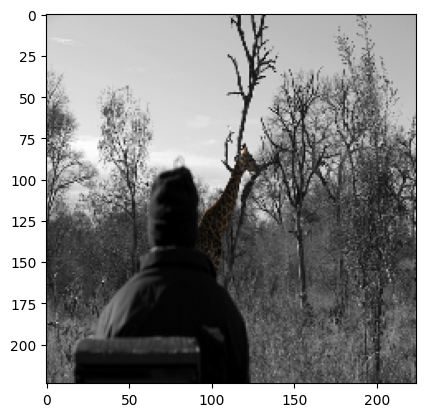

A man standing next to a giraffe in a field.                                                                                        
The back of a man looking at an adult giraff.


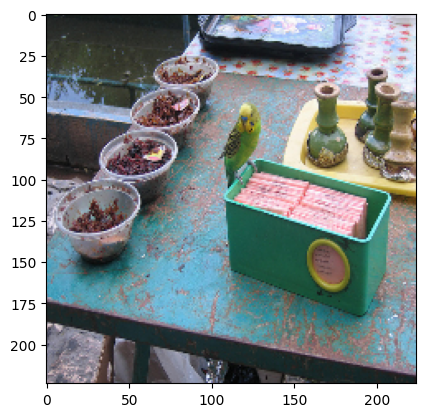

A bird sitting on top of a table next to a bowl of food.                                                                                     
A yellow and green parakeet stands on a table setting. 


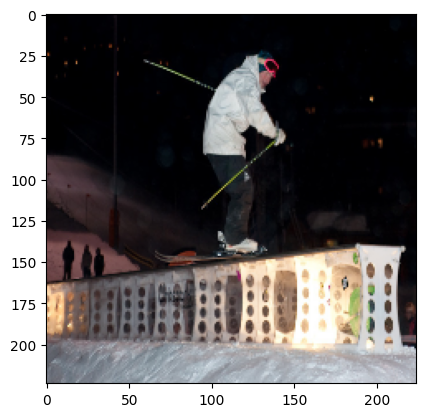

A man riding a snowboard down a ramp.                                                                                          
A man on skis doing tricks in the snow


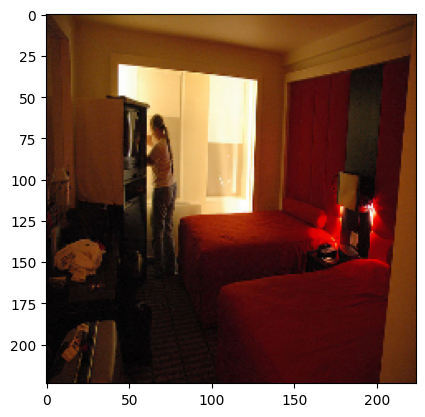

A woman standing in a room with a suitcase.                                                                                          
A woman in a hotel room with two beds and a television.


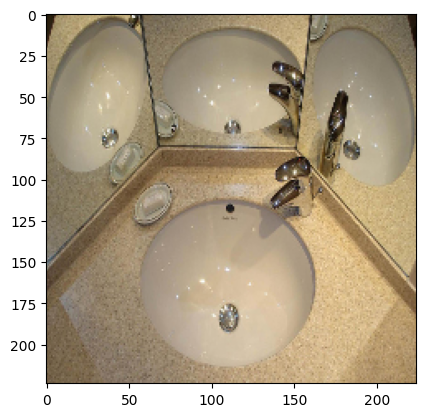

A bathroom sink with a mirror and a mirror.                                                                                          
A sink and facet surrounded by three mirrors.


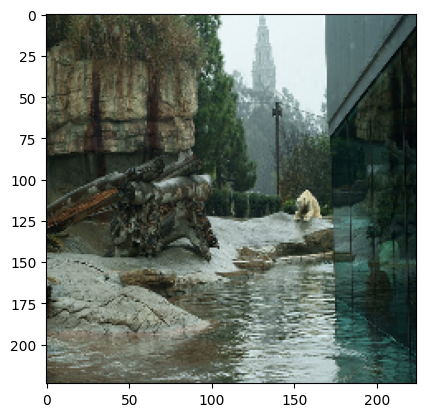

A polar bear is standing in the water near a large rock.                                                                                       
Polar bear in a styled enclosure at a city zoo.


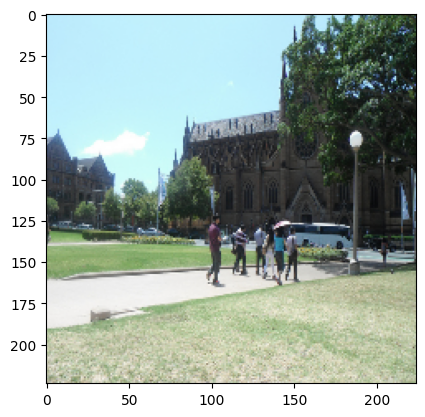

A group of people walking down a street with a clock.                                                                                        
A group of people walking near a cathedral. 


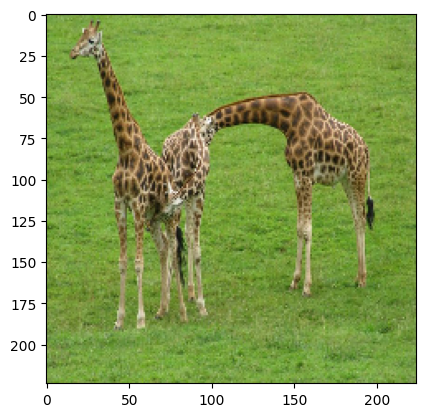

A group of giraffes standing in a grassy field.                                                                                       
Three giraffes are grooming each other in a field


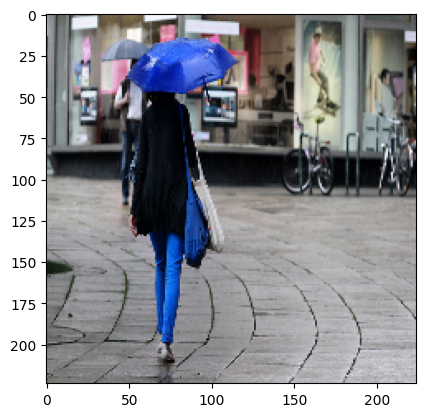

A woman walking down a sidewalk holding an umbrella.                                                                                          
A woman with a blue umbrella walking on a street.


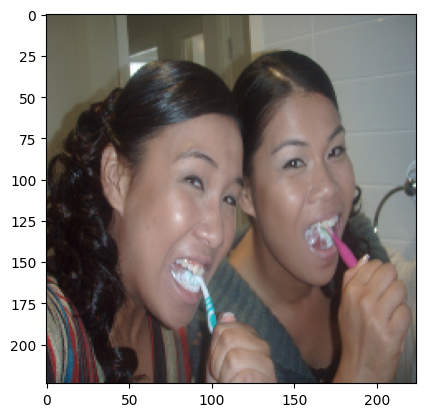

A woman brushing her teeth with a toothbrush.                                                                                          
Two young women pose while brushing their teeth.


In [46]:
n = 0
model.eval()
model.to(device)
for img, inp_ids, labels in val_loader:
    plt.imshow(img[0].permute(1,2,0) * 0.5 + .5)
    plt.show()
    with torch.no_grad():
        out = model.generate(img[0].unsqueeze(0).to(device), 100, greedy=True)
    print(tokenizer.decode(out[0], skip_special_tokens=True))
    labels[labels==-100] = 50256
    print(tokenizer.decode(labels[0], skip_special_tokens=True))
    n += 1
    if n >= 10:
        break
model.train()
gc.collect()
torch.cuda.empty_cache()

In [47]:
# Set the model to evaluation mode
model.eval()

# Create a list to store images and their captions
images_to_log = []

# Iterate over the validation data loader for a single batch
for n, (img, inp_ids, labels) in enumerate(val_loader):
    if n >= 1:
        break
    
    # Loop over each image in the batch
    for i in range(len(img)):
        # Prepare the image
        img_np = img[i].permute(1, 2, 0).cpu().numpy() * 0.5 + 0.5
        
        # Generate captions with the model
        with torch.no_grad():
            out = model.generate(img[i].unsqueeze(0).to(device), max_len=100, greedy=True)
        
        # Decode the generated captions and labels
        generated_caption = tokenizer.decode(out[0], skip_special_tokens=True)
        labels[labels == -100] = tokenizer.pad_token_id
        true_caption = tokenizer.decode(labels[i], skip_special_tokens=True)
        
        # Append the image and captions to the list
        images_to_log.append(wandb.Image(img_np, caption=f"Generated: {generated_caption}\nTrue: {true_caption}"))

# Log the batch of images and their captions to wandb
wandb.log({'images': images_to_log})

model.train()
gc.collect()
torch.cuda.empty_cache()

In [ ]:
n = 0
model.eval()
for img, inp_ids, labels in val_loader:
    plt.imshow(img[0].permute(1,2,0) * 0.5 + .5)
    plt.show()
    with torch.no_grad():
        out = model.generate(img[0].unsqueeze(0).to(device), 100, greedy=False)
    print(tokenizer.decode(out[0], skip_special_tokens=True))
    labels[labels==-100] = 50256
    print(tokenizer.decode(labels[0], skip_special_tokens=True))
    n += 1
    if n >= 5:
        break
model.train()